# Import the necessary libraries

In [11]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np  # Make sure numpy is imported
import tensorflow as tf

# Configure logging
logging.basicConfig(filename='../logs/predict_store_sales_with_deep_learning.log',
                    level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')
  
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../scripts')))
from load_data import Load_Data
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.stattools import adfuller


# Load data set

In [12]:
logging.info("Load cleaned store data")

# Create an instance of CSVReader
df = Load_Data('../data/combined_cleaned_data.csv')

# Load the data
df.load_data()

# Get the loaded data
df = df.get_data()


Data successfully loaded from ../data/combined_cleaned_data.csv


In [13]:
print(df.dtypes)


Store                          int64
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
DayOfWeek                      int64
Date                          object
Sales                        float64
Customers                      int64
Open                           int64
Promo                          int64
SchoolHoliday                  int64
StoreType_b                     bool
StoreType_c                     bool
StoreType_d                     bool
Assortment_b                    bool
Assortment_c                    bool
StateHoliday_a                  bool
StateHoliday_b                  bool
StateHoliday_c                  bool
IsWeekend                      int64
MonthDay                       int64
IsBeginningOfMonth             int64
IsMidMonth                     int64
I

# LSTM Implementation

c:\Users\wubeshet.abera\Projects\Ten-Academy\Sales-Prediction-Model\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 0.0650
Epoch 2/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0543
Epoch 3/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0529
Epoch 4/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0535
Epoch 5/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.0528
Epoch 6/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0540
Epoch 7/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0535
Epoch 8/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0529
Epoch 9/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0535
Epoch 10/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0537
Epoch 11/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0528
Epoch 12/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0532
Epoch 13/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0541
Epoch 14/20
2543/2543 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 0.0541
Epoch 15/20
254

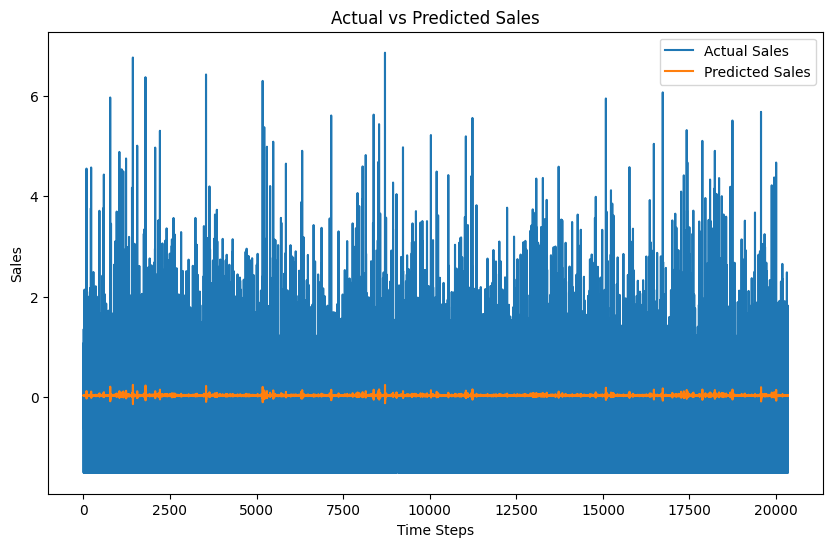

In [14]:
# Sample the data (downsample to 10% for memory efficiency)
logging.info("Sampling the data to 10% for memory efficiency.")
df = df.sample(frac=0.1, random_state=42)  # Use 10% of the data

# Preprocess the data
logging.info("Preprocessing the data.")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Sales']].astype(np.float32)  # Convert to float32 for memory efficiency

# Check if the time series data is stationary using ADF test
logging.info("Performing ADF test to check stationarity.")
result = adfuller(df['Sales'])
logging.info(f'ADF Statistic: {result[0]}')
logging.info(f'p-value: {result[1]}')

# If p-value > 0.05, the series is not stationary; apply differencing
if result[1] > 0.05:
    logging.info("Data is not stationary. Applying differencing.")
    df['Sales'] = df['Sales'].diff().dropna()
else:
    logging.info("Data is stationary. No differencing required.")

# Transform the time series data into supervised learning format (sliding window)
logging.info("Transforming the time series data into supervised learning format.")
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data between (-1, 1)
logging.info("Scaling the data between (-1, 1).")
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df['Sales'].values.reshape(-1, 1))

# Create sliding window data with time_step = 5
logging.info("Creating sliding window data with time_step=5.")
time_step = 5
X, y = create_dataset(data_scaled, time_step)

# Reshape input to be [samples, time steps, features] for LSTM input
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets
logging.info("Splitting the data into training and testing sets.")
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
logging.info("Building the LSTM model.")
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50))
model.add(Dense(1))

# Compile the model
logging.info("Compiling the model.")
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
logging.info("Training the model.")
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Predict on the test set
logging.info("Making predictions on the test set.")
y_pred = model.predict(X_test)

# Inverse transform to get the actual sales values
logging.info("Inverse transforming to get actual sales values.")
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calculate RMSE
logging.info("Calculating RMSE.")
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
logging.info(f'Test RMSE: {rmse}')

# Plot the results
logging.info("Plotting the results.")
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual Sales')
plt.plot(y_pred_inv, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time Steps')
plt.ylabel('Sales')
plt.legend()
plt.show()

logging.info("Process complete.")

# Serialize Deep learning model

In [17]:
import pickle
import datetime
import os

# Generate timestamp in the format dd-mm-yyyy-hh-mm-ss-ms
timestamp = datetime.datetime.now().strftime("%d-%m-%Y-%H-%M-%S-%f")[:-3]

# Define the folder where you want to save the models
save_folder = '../saved_models'  # Adjust the path as needed

# Ensure the folder exists
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Serialize model architecture to JSON
model_json = model.to_json()

# Serialize model weights
weights_filename = f"{save_folder}/model_weights-{timestamp}.pkl"
with open(weights_filename, 'wb') as file:
    pickle.dump(model.get_weights(), file)

# Serialize model architecture to pickle
architecture_filename = f"{save_folder}/model_architecture-{timestamp}.pkl"
with open(architecture_filename, 'wb') as file:
    pickle.dump(model_json, file)

# Print confirmation
print(f"Model architecture saved as {architecture_filename}")
print(f"Model weights saved as {weights_filename}")


Model architecture saved as ../saved_models/model_architecture-23-09-2024-17-28-04-042.pkl
Model weights saved as ../saved_models/model_weights-23-09-2024-17-28-04-042.pkl
